In [32]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score , GridSearchCV
from sklearn.linear_model import SGDRegressor,LinearRegression
from sklearn.metrics import  mean_absolute_error,mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingRegressor

# machine_data 데이터셋 로드
data = pd.read_csv('machine_data.csv')
data

,VendorName,ModelName,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP
0,adviser,32/60,125,256,6000,256,16,128,198
1,amdahl,470v/7,29,8000,32000,32,8,32,269
2,amdahl,470v/7a,29,8000,32000,32,8,32,220
3,amdahl,470v/7b,29,8000,32000,32,8,32,172
4,amdahl,470v/7c,29,8000,16000,32,8,16,132
...,...,...,...,...,...,...,...,...,...
204,sperry,Aug-80,124,1000,8000,0,1,8,42
205,sperry,90/80-model-3,98,1000,8000,32,2,8,46
206,sratus,32,125,2000,8000,0,2,14,52
207,wang,vs-100,480,512,8000,32,0,0,67


2. 데이터 탐색

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   VendorName  209 non-null    object
 1   ModelName   209 non-null    object
 2   MYCT        209 non-null    int64 
 3   MMIN        209 non-null    int64 
 4   MMAX        209 non-null    int64 
 5   CACH        209 non-null    int64 
 6   CHMIN       209 non-null    int64 
 7   CHMAX       209 non-null    int64 
 8   PRP         209 non-null    int64 
dtypes: int64(7), object(2)
memory usage: 14.8+ KB
None
  VendorName ModelName  MYCT  MMIN   MMAX  CACH  CHMIN  CHMAX  PRP
0    adviser     32/60   125   256   6000   256     16    128  198
1     amdahl    470v/7    29  8000  32000    32      8     32  269
2     amdahl   470v/7a    29  8000  32000    32      8     32  220
3     amdahl   470v/7b    29  8000  32000    32      8     32  172
4     amdahl   470v/7c    29  8000  16000    32      8     16  13

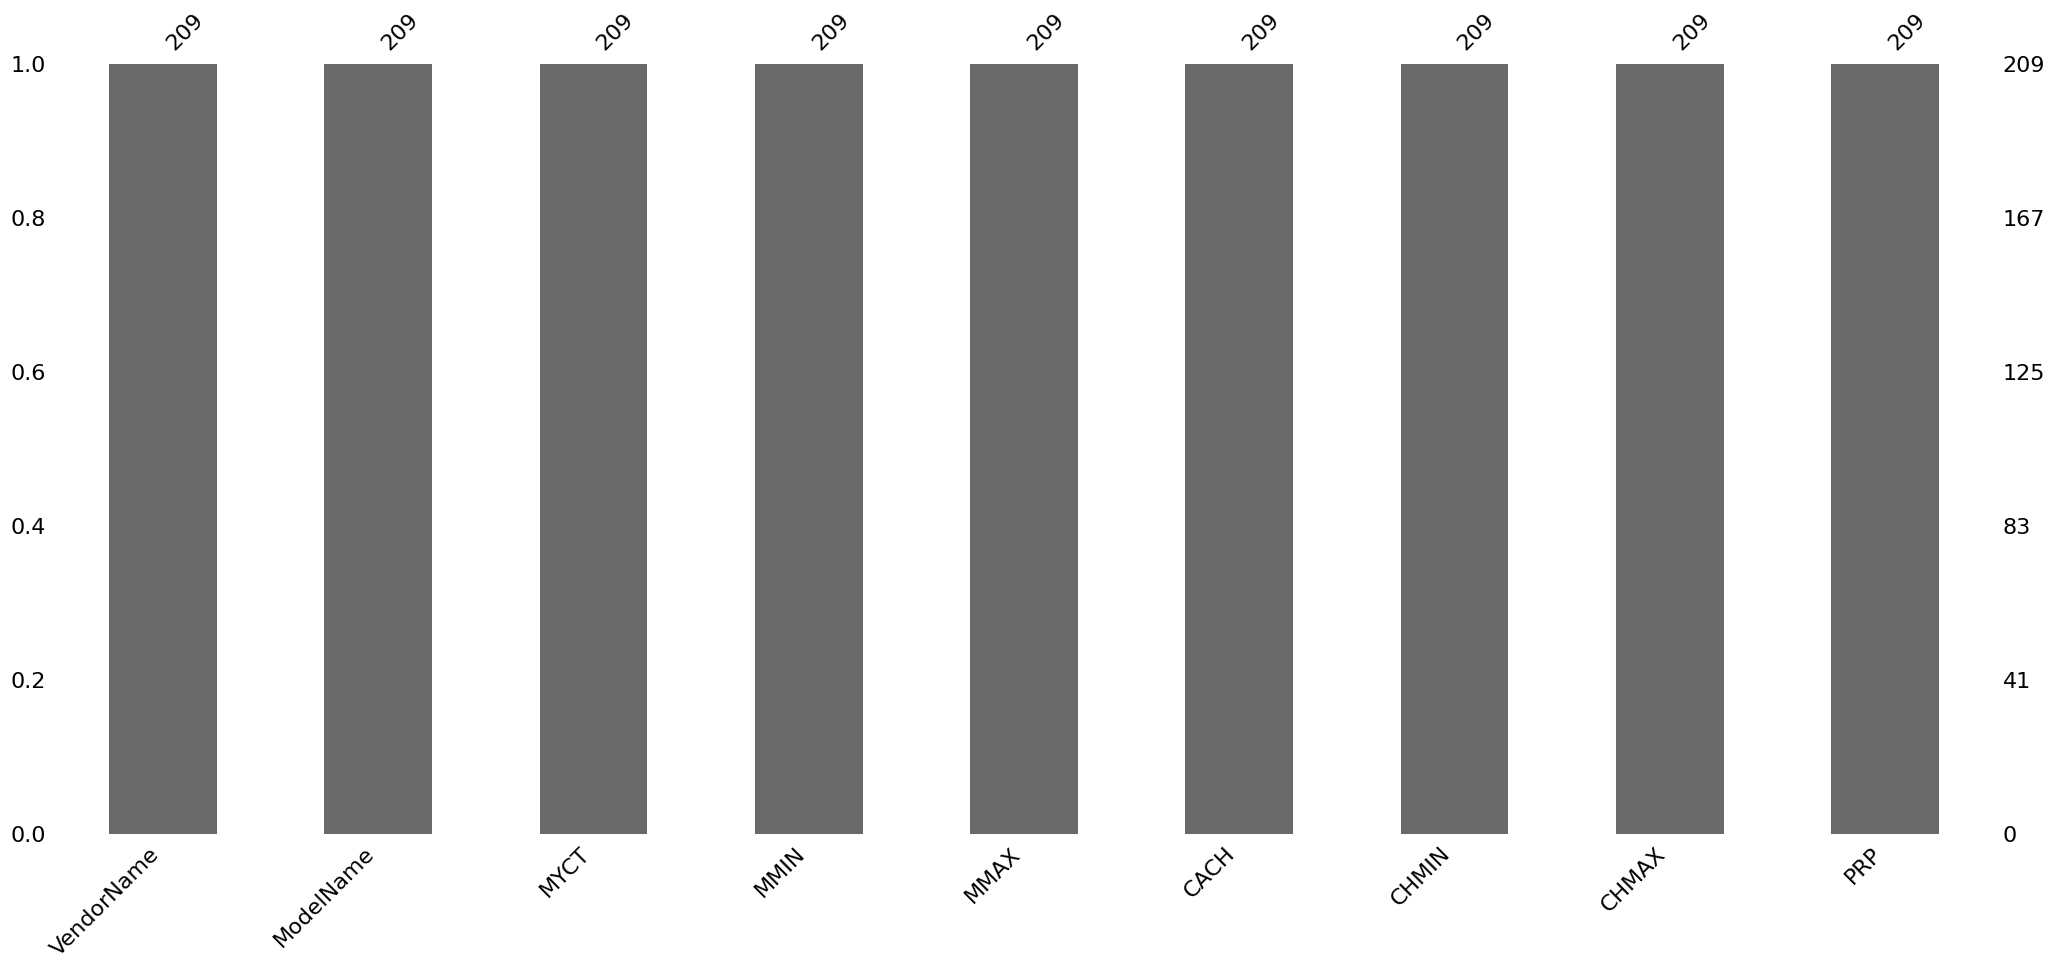

(209, 9)


In [18]:
print(data.info())
print(data.head())
print(data.describe())
print(data.isnull().sum())

msn.bar(data)
plt.show()

data.dropna(inplace=True)
print(data.shape)


3.feature 중요 특징 추출

PRP      1.000000
MMAX     0.863004
MMIN     0.794931
CACH     0.662641
CHMIN    0.608903
CHMAX    0.605209
MYCT     0.307099
Name: PRP, dtype: float64
Top features: Index(['MMAX', 'MMIN', 'CACH', 'CHMIN'], dtype='object')


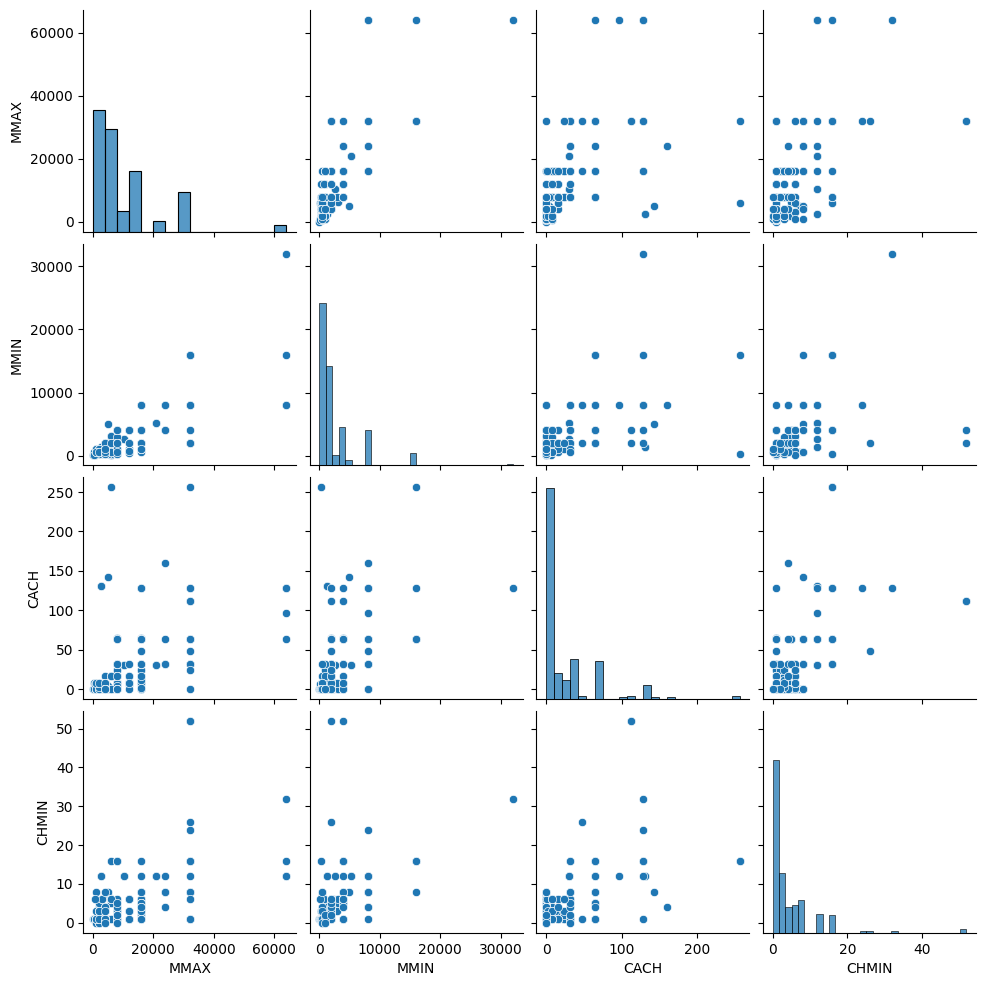

In [19]:
numeric_data = data.select_dtypes(include=[np.number])
correlation_matrix = numeric_data.corr()
correlation_with_target = correlation_matrix['PRP'].abs().sort_values(ascending=False)
sorted_correlation = correlation_with_target.sort_values(ascending=False)
print(sorted_correlation)

top_features = sorted_correlation.index[1:5]
print(f'Top features: {top_features}')

sns.pairplot(data, vars=top_features)
plt.show()

4. x,y 설정

In [20]:
X = data[top_features]  # 2차원 표
y = data['PRP']  # 1차원 시리즈

5. 학습 데이터와 평가 데이터 분리

In [21]:
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(209, 4) (209,)
(167, 4) (42, 4) (167,) (42,)


6. 앙상블 기법을 이용한 모델 학습

In [54]:
# 전처리
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 개별 모델 정의
lr = LinearRegression()
sgd = SGDRegressor()

# 앙상블 모델 정의
ensemble = VotingRegressor(estimators=[('lr', lr), ('sgd', sgd)])

# 하이퍼파라미터 튜닝
params_grid = {
    "sgd__alpha": [0.0001, 0.1, 1.0],
    "sgd__max_iter": [1000, 2000, 3000],
}

# GridSearchCV 설정 및 모델 학습
grid_search = GridSearchCV(ensemble, params_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train_scaled, y_train)


GridSearchCV(cv=5,
             estimator=VotingRegressor(estimators=[('lr', LinearRegression()),
                                                   ('sgd', SGDRegressor())]),
             param_grid={'sgd__alpha': [0.0001, 0.1, 1.0],
                         'sgd__max_iter': [1000, 2000, 3000]},
             return_train_score=True, scoring='neg_mean_squared_error')

7. 최적 파라미터 출력 및 최적 모델로 예측

In [55]:
print(f'Best parameters: {grid_search.best_params_}')
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

Best parameters: {'sgd__alpha': 0.1, 'sgd__max_iter': 2000}


8. 예측 모델 성능 평가

MSE: 7327.710292825756, MAE: 48.4707527097255, R^2: 0.8600533043886999


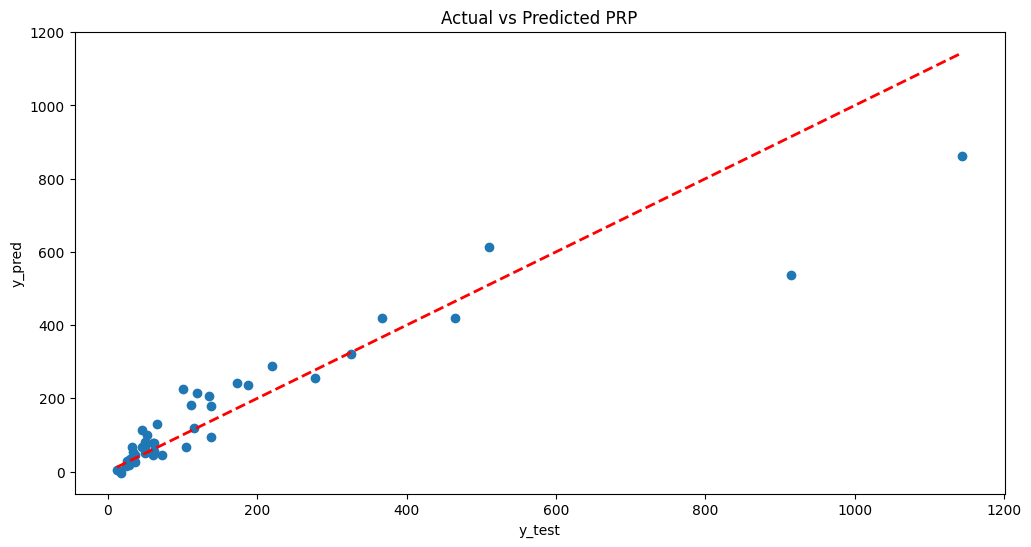

In [56]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse}, MAE: {mae}, R^2: {r2}")

plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.title("Actual vs Predicted PRP")
plt.savefig('prp_prediction.jpg')

9. 베스트 모델 결과 시각화

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_sgd__alpha', 'param_sgd__eta0', 'param_sgd__learning_rate',
       'param_sgd__max_iter', 'param_sgd__penalty', 'param_sgd__power_t',
       'params', 'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'split3_train_score',
       'split4_train_score', 'mean_train_score', 'std_train_score'],
      dtype='object')


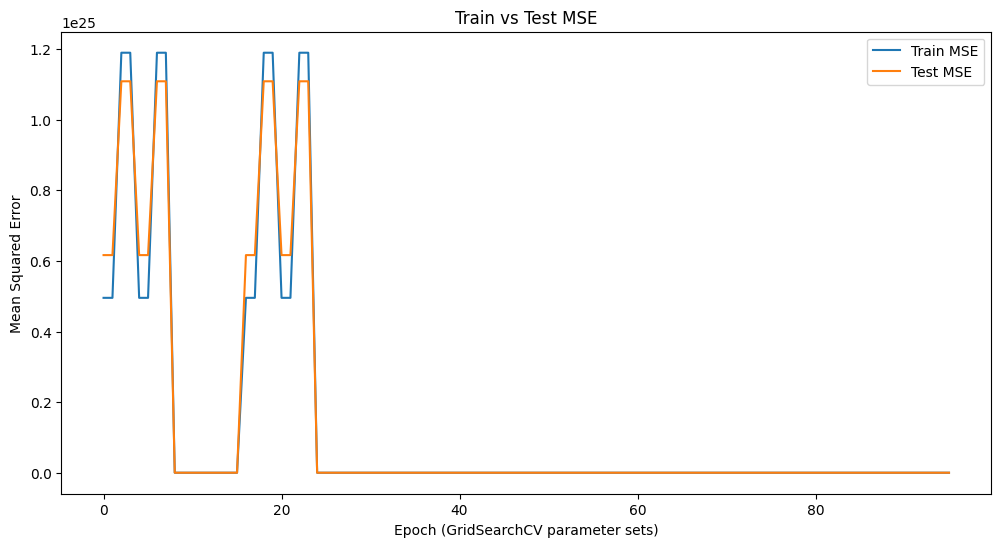

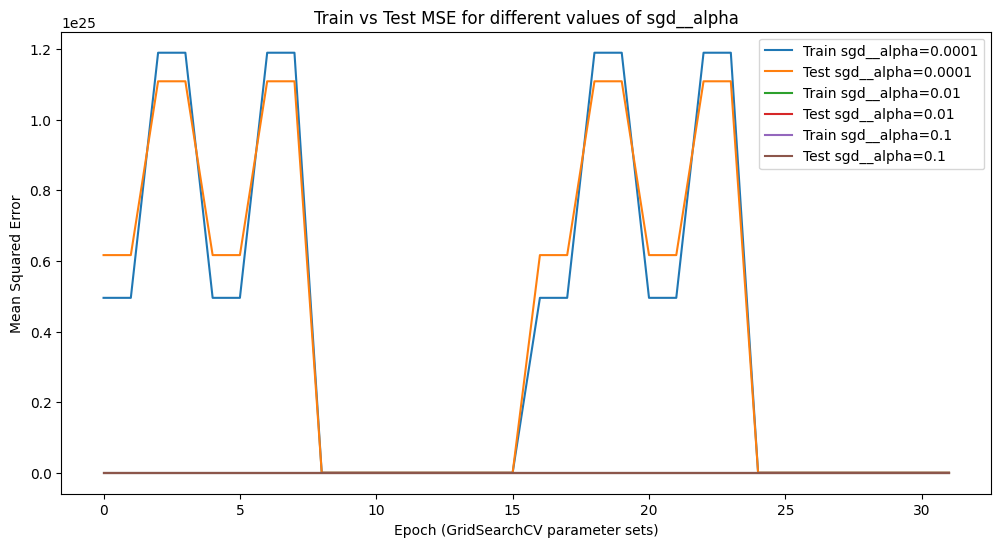

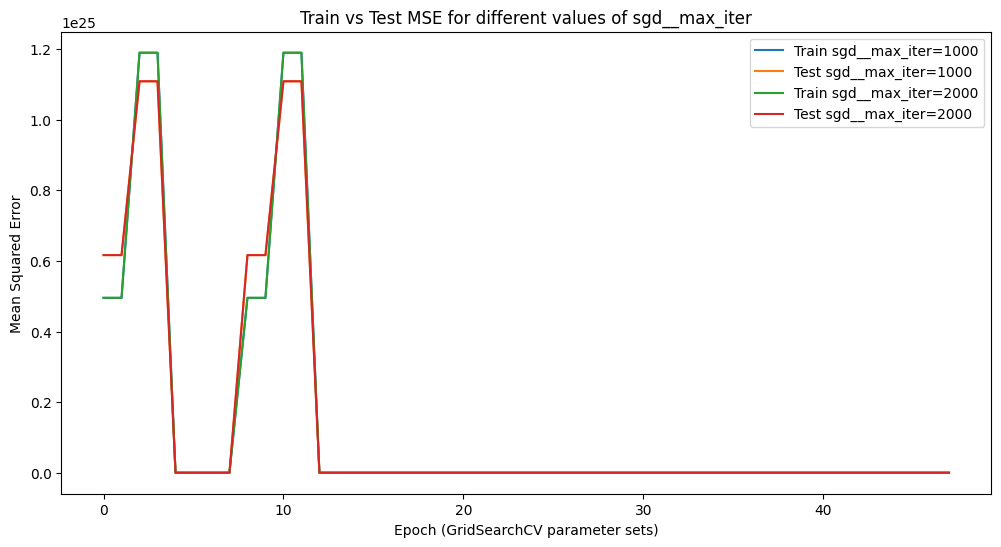

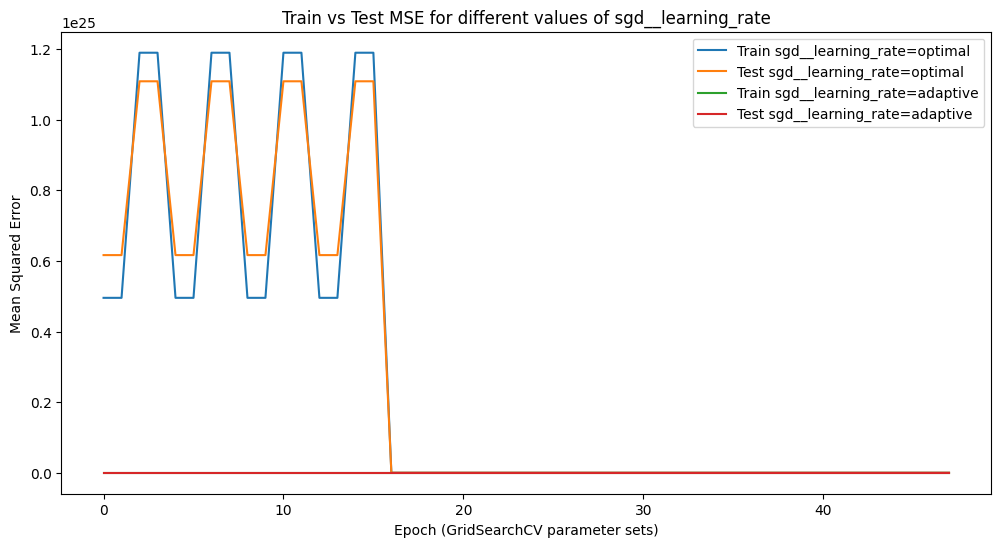

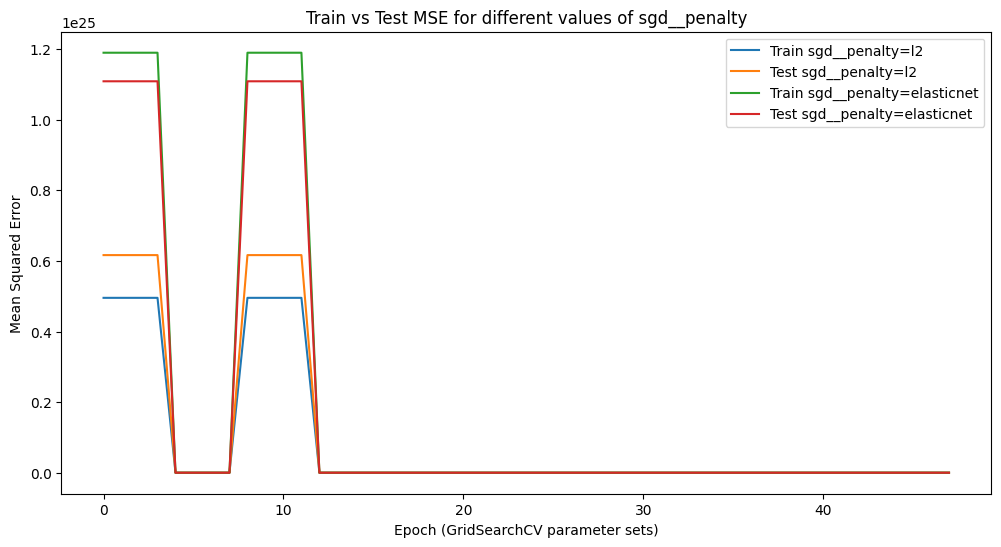

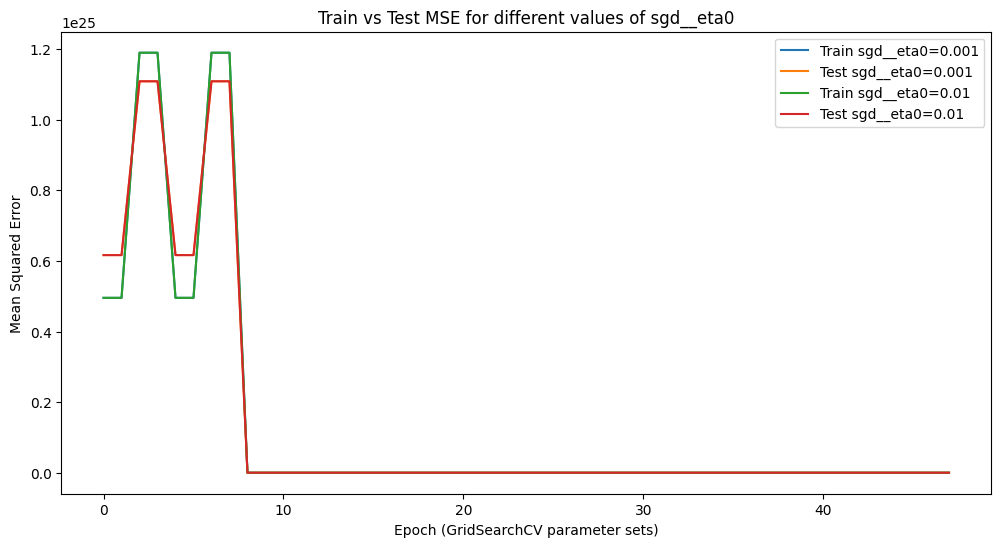

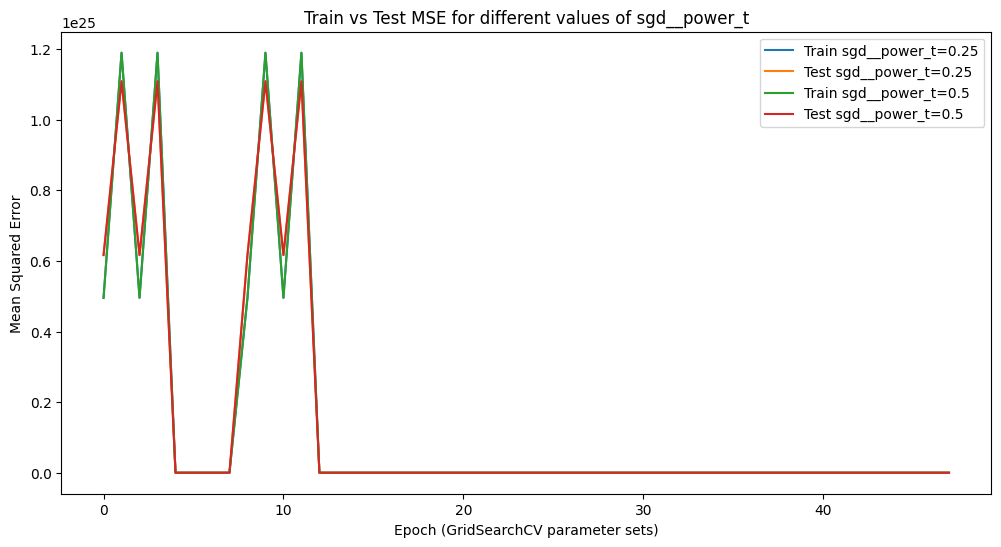

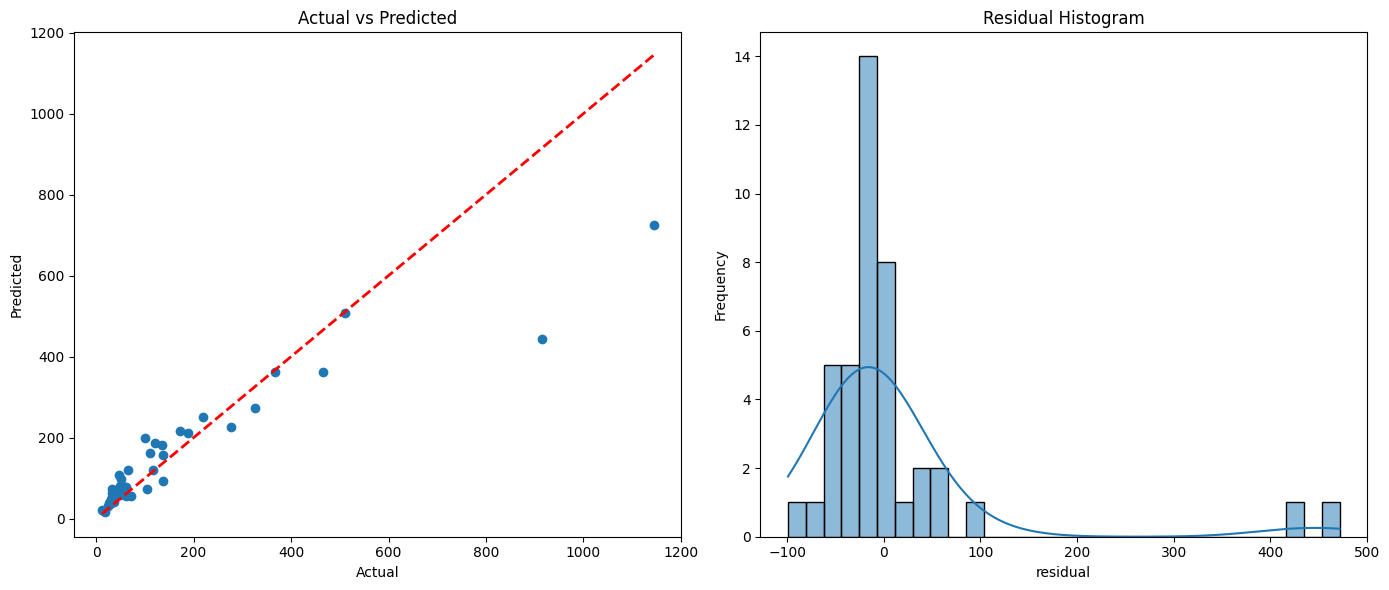

Final R^2 value: 0.7923755888424358


In [52]:
results = pd.DataFrame(grid_search.cv_results_)
print(results.columns)

# 에폭을 X축으로, 훈련 점수 및 테스트 점수 시각화
plt.figure(figsize=(12, 6))
plt.plot(range(len(results['mean_train_score'])), -results['mean_train_score'], label='Train MSE')
plt.plot(range(len(results['mean_test_score'])), -results['mean_test_score'], label='Test MSE')
plt.xlabel('Epoch (GridSearchCV parameter sets)')
plt.ylabel('Mean Squared Error')
plt.title('Train vs Test MSE')
plt.legend()
plt.show()

# 더 많은 파라미터에 대한 시각화
for param in params_grid:
    plt.figure(figsize=(12, 6))
    for value in results['param_' + param].unique():
        subset = results[results['param_' + param] == value]
        plt.plot(range(len(subset)), -subset['mean_train_score'], label=f'Train {param}={value}')
        plt.plot(range(len(subset)), -subset['mean_test_score'], label=f'Test {param}={value}')
    plt.xlabel('Epoch (GridSearchCV parameter sets)')
    plt.ylabel('Mean Squared Error')
    plt.title(f'Train vs Test MSE for different values of {param}')
    plt.legend()
    plt.show()

plt.figure(figsize=(14, 6))
# 실제 vs 예측 비교
plt.subplot(1, 2, 1)  # 1행 2열
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel("Predicted")
plt.title('Actual vs Predicted')

# 잔차 히스토그램
plt.subplot(1, 2, 2)
sns.histplot(y_test - y_pred, kde=True)
plt.xlabel('residual')
plt.ylabel('Frequency')
plt.title('Residual Histogram')
plt.tight_layout()
plt.show()

print(f"Final R^2 value: {r2}")